<a href="https://colab.research.google.com/github/hosseinrezaie0/Heart-Failure-Prediction/blob/main/HeartFailure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [121]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, auc, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/content/heart.csv')

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
df.shape

(918, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
df.isna().sum()

,0
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [7]:
# Shuffle the Dataset
df = df.sample(frac=1, random_state=42)

In [8]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

### EDA

#### Plot the data

In [11]:
numerical_columns = df.select_dtypes(include={'int64', 'float64'}).columns
categorical_columns = df.select_dtypes(include={'object'}).columns

In [12]:
numerical_columns, categorical_columns

(Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
        'HeartDisease'],
       dtype='object'),
 Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object'))

Upon examining the plot, it becomes evident that approximately 170 samples have a cholesterol value of zero. Since a cholesterol level of zero is physiologically implausible, these zero values should be treated as missing or invalid data.
also for oldpeak column there 13 values samller than 0 which is impossible so they will be replaced with 0 in the future

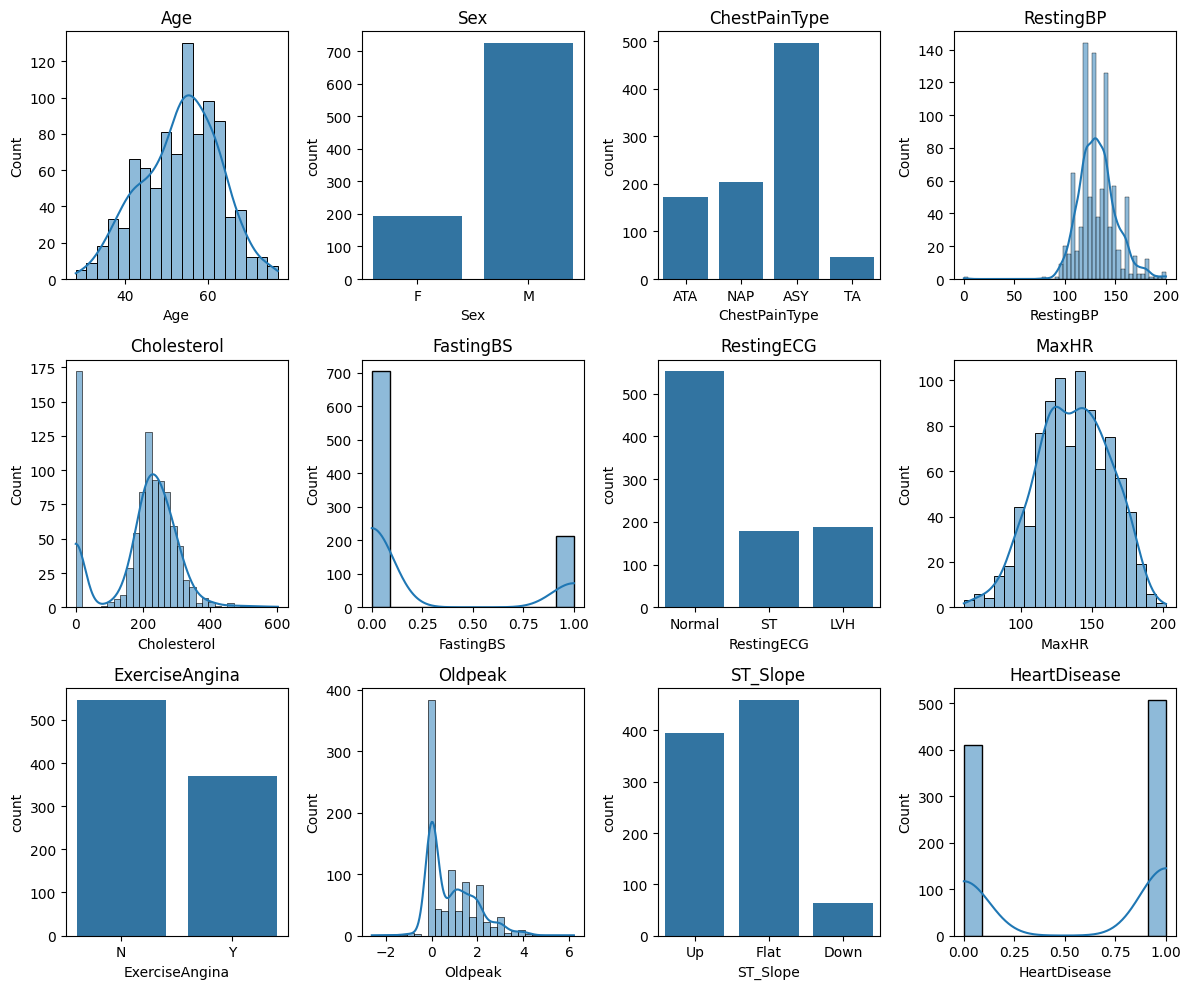

In [13]:
fig, ax = plt.subplots(3, 4, figsize=(12, 10))
ax = ax.flatten()

for i, col in enumerate(df.columns):
    if col in numerical_columns:
        sns.histplot(data=df, x=col, ax=ax[i], kde=True)
    else:
        sns.countplot(data=df, x=col, ax=ax[i])
    ax[i].set_title(col)

plt.tight_layout()
plt.show()


#### Create the piepline

In [14]:
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

In [15]:
categorical_pipline = Pipeline([
    ('encoder', OrdinalEncoder())
])

In [16]:
def Log1p(X):
  X = np.where(X < 0, 0, X)
  return np.log1p(X)
heavy_tail_pipeline = Pipeline([
    ('log', FunctionTransformer(Log1p, feature_names_out='one-to-one')),
    ('scaler', StandardScaler())
])

In [17]:
df['Cholesterol'] = df['Cholesterol'].replace(0, np.nan)
estimator = RandomForestRegressor(max_depth=5, n_estimators=20, random_state=42)
imputer = IterativeImputer(estimator, missing_values=0)
cholestrol_pipeline = Pipeline([
    ('imputer', imputer),
    ('sacler', StandardScaler())
])

In [18]:
all_transformation = ColumnTransformer([
    ('scaled', numerical_pipeline, ['Age', 'MaxHR', 'FastingBS']),
    ('encoded', categorical_pipline, ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']),
    ('log', heavy_tail_pipeline, ['Oldpeak', 'RestingBP']),
    ('imputer', cholestrol_pipeline, ['Cholesterol'])
])

In [19]:
x_train_transformed = pd.DataFrame(all_transformation.fit_transform(x_train),
                                   columns=all_transformation.get_feature_names_out())
x_test_transformed = pd.DataFrame(all_transformation.fit_transform(x_test),
                                   columns=all_transformation.get_feature_names_out())

In [20]:
x_train_transformed

,scaled__Age,scaled__MaxHR,scaled__FastingBS,encoded__Sex,encoded__ChestPainType,encoded__RestingECG,encoded__ExerciseAngina,encoded__ST_Slope,log__Oldpeak,log__RestingBP,imputer__Cholesterol
0,0.582256,-0.283594,1.807607,0.0,0.0,2.0,1.0,1.0,0.800669,-0.040604,1.775679e+00
1,-0.050893,-0.679106,-0.553218,1.0,1.0,2.0,0.0,0.0,0.047288,-0.040604,5.319122e-16
2,-0.050893,-1.667887,-0.553218,1.0,1.0,1.0,0.0,1.0,-0.989280,-0.393924,5.319122e-16
3,1.004356,-1.272375,1.807607,1.0,0.0,1.0,1.0,1.0,0.364764,0.876915,-2.455408e-01
4,0.160156,-1.628336,-0.553218,1.0,0.0,1.0,1.0,1.0,1.156829,0.441764,9.132918e-02
...,...,...,...,...,...,...,...,...,...,...,...
729,-0.367468,0.111918,-0.553218,0.0,2.0,1.0,1.0,1.0,-0.989280,0.286713,8.399291e-01
730,-1.528242,-0.204492,-0.553218,1.0,0.0,1.0,0.0,2.0,-0.989280,-0.777739,5.592041e-01
731,-1.106143,-0.600004,1.807607,1.0,0.0,1.0,0.0,0.0,0.800669,-1.197815,5.319122e-16
732,-0.684043,0.744738,-0.553218,1.0,2.0,0.0,0.0,2.0,-0.989280,0.223148,2.597642e-01


### Create the models

In [21]:
eval_report = pd.DataFrame(columns=['Model','Accuracy', 'F1 Score', 'Precision', 'Recall', 'AUC Score'])

In [22]:
def evaluate_model(y, y_pred):
  accuracy = accuracy_score(y, y_pred)
  f1 = f1_score(y, y_pred)
  precision = precision_score(y, y_pred)
  recall = recall_score(y, y_pred)
  fpr, tpr, thresholds = roc_curve(y, y_pred)
  auc_score = auc(fpr, tpr)
  return accuracy, f1, precision, recall, auc_score

In [23]:
def plot_confusion_matrix(y, y_pred):
  cm = confusion_matrix(y, y_pred)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

#### Logistic Regression

In [24]:
logestic_regression_pipeline = make_pipeline(
    all_transformation,
    LogisticRegression(max_iter=1000, class_weight='balanced', random_state=1)
)

In [25]:
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear','saga']
    }

In [26]:
lr_model = GridSearchCV(logestic_regression_pipeline, param_grid, cv=5, scoring='accuracy')

In [27]:
lr_model.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('scaled',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'MaxHR',
                                                                          'FastingBS']),
                                                                        ('encoded',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['Sex',
                                                                          'ChestPainType',
                                                                          'RestingECG',
                                                                          'ExerciseAngina',
                                                                          'ST_Slope']),
                                                                        ('log',
                                                                         Pipeline(steps=[('log',
                                                                                          FunctionTransf...
                                                                                                                                           random_state=42),
                                                                                                           missing_values=0)),
                                                                                         ('sacler',
                                                                                          StandardScaler())]),
                                                                         ['Cholesterol'])])),
                                       ('logisticregression',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=1))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100],
                         'logisticregression__penalty': ['l1', 'l2'],
                         'logisticregression__solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [28]:
# Best params
lr_model.best_params_

{'logisticregression__C': 1,
 'logisticregression__penalty': 'l1',
 'logisticregression__solver': 'liblinear'}

In [29]:
# Best score
lr_model.best_score_

np.float64(0.8515049855558662)

In [ ]:
y_pred = lr_model.predict(x_test)

In [31]:
# Test the model
accuracy, f1, precision, recall, auc_score = evaluate_model(y_test, y_pred)

In [32]:
# Add the result to the report
eval_report.loc[len(eval_report)] = {
    'Model': 'Logistic Regression',
    'Accuracy': accuracy,
    'F1 Score': f1,
    'Precision': precision,
    'Recall': recall,
    'AUC Score': auc_score
}

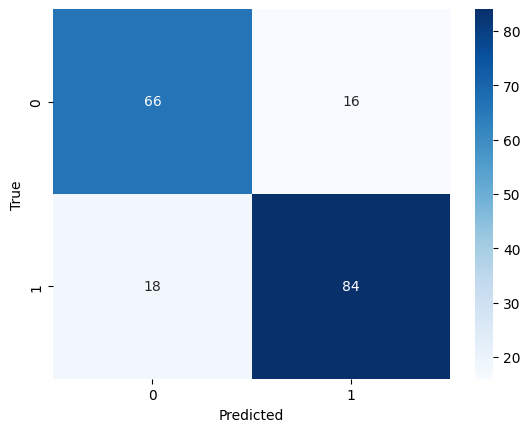

In [34]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

#### Naive Bayes

In [ ]:
# for continuous features, GaussianNB is used
# for categorical features, BernoulliNB is used

x_train_continuous = x_train_transformed[['scaled__Age', 'scaled__MaxHR', 'scaled__FastingBS', 'log__Oldpeak', 'log__RestingBP', 'imputer__Cholesterol']]
x_train_categorical = x_train_transformed[['encoded__Sex', 'encoded__ChestPainType', 'encoded__RestingECG', 'encoded__ExerciseAngina', 'encoded__ST_Slope']]

x_test_continuous = x_test_transformed[['scaled__Age', 'scaled__MaxHR', 'scaled__FastingBS', 'log__Oldpeak', 'log__RestingBP', 'imputer__Cholesterol']]
x_test_categorical = x_test_transformed[['encoded__Sex', 'encoded__ChestPainType', 'encoded__RestingECG', 'encoded__ExerciseAngina', 'encoded__ST_Slope']]


# create models
gaussian_model = GaussianNB()
bernoulli_model = BernoulliNB()

# fit the models
gaussian_model.fit(x_train_continuous, y_train)
bernoulli_model.fit(x_train_categorical, y_train)

# get the probabilities
probs_gaussian = gaussian_model.predict_proba(x_test_continuous)
probs_bernoulli = bernoulli_model.predict_proba(x_test_categorical)

# combine the probabilities (average)
combined_probs = (probs_gaussian + probs_bernoulli) / 2

# make predictions
y_pred = np.argmax(combined_probs, axis=1)

In [ ]:
# evaluate the model
accuracy, f1, precision, recall, auc_score = evaluate_model(y_test, y_pred)

In [ ]:
# Add the result to the report
eval_report.loc[len(eval_report)] = {
    'Model': 'Naive Bayes',
    'Accuracy': accuracy,
    'F1 Score': f1,
    'Precision': precision,
    'Recall': recall,
    'AUC Score': auc_score
}

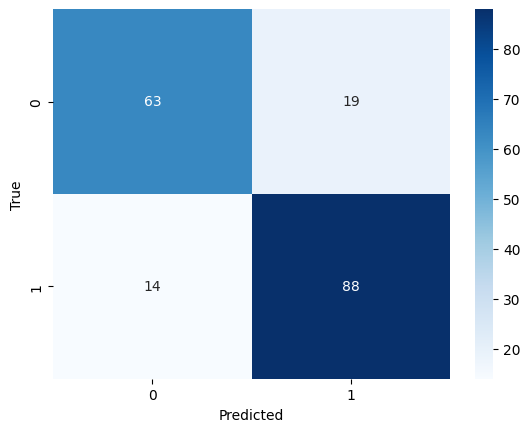

In [ ]:
# plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

#### K Nearest Neighbors

In [41]:
knn_pipeline = make_pipeline(
    all_transformation,
    KNeighborsClassifier(algorithm="auto")
)

In [42]:
param_grid = {
    "kneighborsclassifier__leaf_size": [20, 30, 40],
    "kneighborsclassifier__p": [1, 2, 3],
    "kneighborsclassifier__n_neighbors": [5, 7, 9],
    "kneighborsclassifier__weights": ["uniform", "distance"]
}

In [37]:
knn_model = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='accuracy')

In [38]:
knn_model.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('scaled',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'MaxHR',
                                                                          'FastingBS']),
                                                                        ('encoded',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['Sex',
                                                                          'ChestPainType',
                                                                          'RestingECG',
                                                                          'ExerciseAngina',
                                                                          'ST_Slope']),
                                                                        ('log',
                                                                         Pipeline(steps=[('log',
                                                                                          FunctionTransf...
                                                                                                                                           n_estimators=20,
                                                                                                                                           random_state=42),
                                                                                                           missing_values=0)),
                                                                                         ('sacler',
                                                                                          StandardScaler())]),
                                                                         ['Cholesterol'])])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__leaf_size': [20, 30, 40],
                         'kneighborsclassifier__n_neighbors': [5, 7, 9],
                         'kneighborsclassifier__p': [1, 2, 3],
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']},
             scoring='accuracy')

In [43]:
knn_model.best_params_

{'kneighborsclassifier__leaf_size': 20,
 'kneighborsclassifier__n_neighbors': 9,
 'kneighborsclassifier__p': 1,
 'kneighborsclassifier__weights': 'uniform'}

In [44]:
knn_model.best_score_

np.float64(0.8583263442363247)

In [45]:
y_pred = knn_model.predict(x_test)

In [46]:
accuracy, f1, precision, recall, auc_score = evaluate_model(y_test, y_pred)

In [47]:
eval_report.loc[len(eval_report)] = {
    'Model': 'K Nearest Neighbors',
    'Accuracy': accuracy,
    'F1 Score': f1,
    'Precision': precision,
    'Recall': recall,
    'AUC Score': auc_score
}

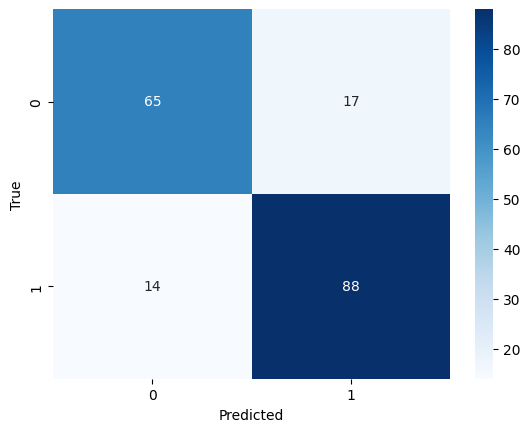

In [48]:
# plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

#### Decision Tree

In [49]:
dt_pipeline = make_pipeline(
    all_transformation,
    DecisionTreeClassifier(random_state=42)
)

In [50]:
param_grid = {
    "decisiontreeclassifier__criterion": ["gini", "entropy"],
    "decisiontreeclassifier__max_depth": [None, 10, 20, 30],
    "decisiontreeclassifier__min_samples_split": [2, 5, 10],
    "decisiontreeclassifier__min_samples_leaf": [1, 2, 4],
    "decisiontreeclassifier__max_features": ["auto", "sqrt", "log2"]
}

In [54]:
dt_model = GridSearchCV(dt_pipeline, param_grid, cv=5)

In [63]:
dt_model.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('scaled',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'MaxHR',
                                                                          'FastingBS']),
                                                                        ('encoded',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['Sex',
                                                                          'ChestPainType',
                                                                          'RestingECG',
                                                                          'ExerciseAngina',
                                                                          'ST_Slope']),
                                                                        ('log',
                                                                         Pipeline(steps=[('log',
                                                                                          FunctionTransf...
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy'],
                         'decisiontreeclassifier__max_depth': [None, 10, 20,
                                                               30],
                         'decisiontreeclassifier__max_features': ['auto',
                                                                  'sqrt',
                                                                  'log2'],
                         'decisiontreeclassifier__min_samples_leaf': [1, 2, 4],
                         'decisiontreeclassifier__min_samples_split': [2, 5,
                                                                       10]})

In [57]:
dt_model.best_params_

{'decisiontreeclassifier__criterion': 'gini',
 'decisiontreeclassifier__max_depth': 10,
 'decisiontreeclassifier__max_features': 'sqrt',
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 5}

In [58]:
y_pred = dt_model.predict(x_test)

In [59]:
accuracy, f1, precision, recall, auc_score = evaluate_model(y_test, y_pred)

In [60]:
eval_report.loc[len(eval_report)] = {
    'Model': 'Decision Tree',
    'Accuracy': accuracy,
    'F1 Score': f1,
    'Precision': precision,
    'Recall': recall,
    'AUC Score': auc_score
}

In [61]:
eval_report

,Model,Accuracy,F1 Score,Precision,Recall,AUC Score
0,Logistic Regression,0.815217,0.831683,0.840000,0.823529,0.814204
1,K Nearest Neighbors,0.831522,0.850242,0.838095,0.862745,0.827714
2,Decision Tree,0.809783,0.827586,0.831683,0.823529,0.808106


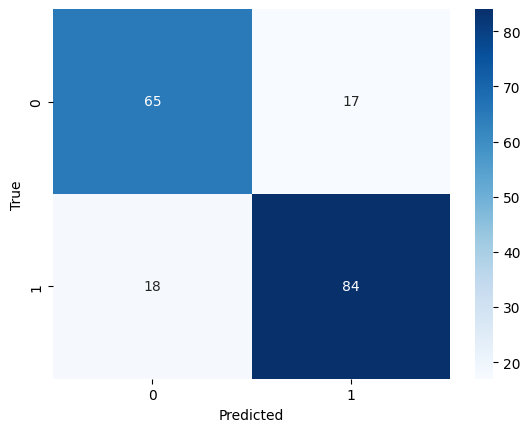

In [62]:
# plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

#### Random Forest

In [65]:
rf_pipeline = make_pipeline(
    all_transformation,
    RandomForestClassifier(random_state=42)
)

In [66]:
param_grid = {
    "randomforestclassifier__n_estimators": [10, 20, 30],
    "randomforestclassifier__max_depth": [None, 10, 20, 30],
    "randomforestclassifier__min_samples_split": [2, 5, 10],
    "randomforestclassifier__min_samples_leaf": [1, 2, 4],
    "randomforestclassifier__max_features": ["auto", "sqrt", "log2"]}

In [67]:
rf_model = GridSearchCV(rf_pipeline, param_grid, cv=5)

In [68]:
rf_model.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('scaled',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'MaxHR',
                                                                          'FastingBS']),
                                                                        ('encoded',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['Sex',
                                                                          'ChestPainType',
                                                                          'RestingECG',
                                                                          'ExerciseAngina',
                                                                          'ST_Slope']),
                                                                        ('log',
                                                                         Pipeline(steps=[('log',
                                                                                          FunctionTransf...
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'randomforestclassifier__max_depth': [None, 10, 20,
                                                               30],
                         'randomforestclassifier__max_features': ['auto',
                                                                  'sqrt',
                                                                  'log2'],
                         'randomforestclassifier__min_samples_leaf': [1, 2, 4],
                         'randomforestclassifier__min_samples_split': [2, 5,
                                                                       10],
                         'randomforestclassifier__n_estimators': [10, 20, 30]})

In [80]:
rf_model.best_params_

{'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 20}

In [69]:
y_pred = rf_model.predict(x_test)

In [70]:
accuracy, f1, precision, recall, auc_score = evaluate_model(y_test, y_pred)

In [73]:
eval_report.loc[len(eval_report)] = {
    'Model': 'Random Forest',
    'Accuracy': accuracy,
    'F1 Score': f1,
    'Precision': precision,
    'Recall': recall,
    'AUC Score': auc_score
}

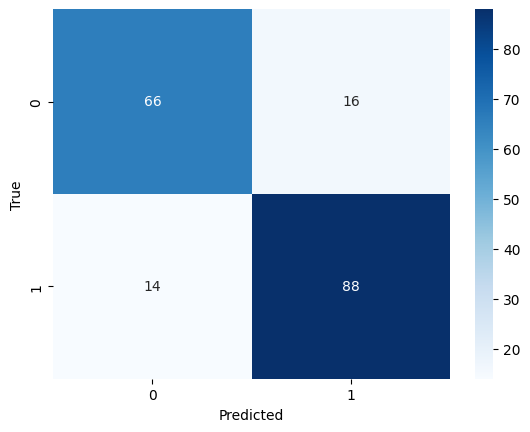

In [75]:
# plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

#### SVC

In [99]:
svc_pipeline = make_pipeline(
    all_transformation,
    SVC(random_state=42, class_weight='balanced')
)

In [100]:
param_grid = {
    "svc__C": [0.01, 0.1, 1, 10, 100],
    "svc__kernel": ["linear", "rbf"],
    "svc__gamma": ["scale", "auto", 0.01, 0.1, 1, 10]
}


In [101]:
svc_model = GridSearchCV(svc_pipeline, param_grid, cv=5)

In [102]:
svc_model.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('scaled',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'MaxHR',
                                                                          'FastingBS']),
                                                                        ('encoded',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['Sex',
                                                                          'ChestPainType',
                                                                          'RestingECG',
                                                                          'ExerciseAngina',
                                                                          'ST...
                                                                         Pipeline(steps=[('imputer',
                                                                                          IterativeImputer(estimator=RandomForestRegressor(max_depth=5,
                                                                                                                                           n_estimators=20,
                                                                                                                                           random_state=42),
                                                                                                           missing_values=0)),
                                                                                         ('sacler',
                                                                                          StandardScaler())]),
                                                                         ['Cholesterol'])])),
                                       ('svc',
                                        SVC(class_weight='balanced',
                                            random_state=42))]),
             param_grid={'svc__C': [0.01, 0.1, 1, 10, 100],
                         'svc__gamma': ['scale', 'auto', 0.01, 0.1, 1, 10],
                         'svc__kernel': ['linear', 'rbf']})

In [103]:
svc_model.best_params_

{'svc__C': 0.1, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}

In [104]:
y_pred = svc_model.predict(x_test)

In [105]:
accuracy, f1, precision, recall, auc_score = evaluate_model(y_test, y_pred)

In [106]:
eval_report.loc[len(eval_report)] = {
    'Model': 'SVC',
    'Accuracy': accuracy,
    'F1 Score': f1,
    'Precision': precision,
    'Recall': recall,
    'AUC Score': auc_score
}

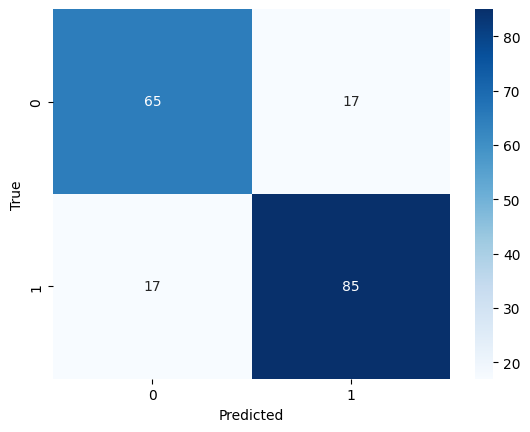

In [108]:
# plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

#### XGBOOST

In [110]:
xgb_pipeline = make_pipeline(
    all_transformation,
    XGBClassifier(
        random_state=1,
        use_label_encoder=False,
        eval_metric='logloss',
    )
)

In [111]:
param_grid = {
    "xgbclassifier__n_estimators": [50, 100, 200],
    "xgbclassifier__max_depth": [3, 5, 7],
    "xgbclassifier__learning_rate": [0.01, 0.1, 0.2],
    "xgbclassifier__subsample": [0.7, 0.8, 1.0],
    "xgbclassifier__colsample_bytree": [0.7, 0.8, 1.0],
    "xgbclassifier__gamma": [0, 0.1, 0.3]
}

In [112]:
xgb_model = GridSearchCV(xgb_pipeline, param_grid, cv=5, n_jobs=-1)

In [113]:
xgb_model.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('scaled',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'MaxHR',
                                                                          'FastingBS']),
                                                                        ('encoded',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['Sex',
                                                                          'ChestPainType',
                                                                          'RestingECG',
                                                                          'ExerciseAngina',
                                                                          'ST_Slope']),
                                                                        ('log',
                                                                         Pipeline(steps=[('log',
                                                                                          FunctionTransf...
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__colsample_bytree': [0.7, 0.8, 1.0],
                         'xgbclassifier__gamma': [0, 0.1, 0.3],
                         'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
                         'xgbclassifier__max_depth': [3, 5, 7],
                         'xgbclassifier__n_estimators': [50, 100, 200],
                         'xgbclassifier__subsample': [0.7, 0.8, 1.0]})

In [114]:
xgb_model.best_params_

{'xgbclassifier__colsample_bytree': 0.8,
 'xgbclassifier__gamma': 0.3,
 'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__max_depth': 3,
 'xgbclassifier__n_estimators': 100,
 'xgbclassifier__subsample': 0.8}

In [115]:
y_pred = xgb_model.predict(x_test)

In [116]:
accuracy, f1, precision, recall, auc_score = evaluate_model(y_test, y_pred)

In [117]:
eval_report.loc[len(eval_report)] = {
    'Model': 'XGBoost',
    'Accuracy': accuracy,
    'F1 Score': f1,
    'Precision': precision,
    'Recall': recall,
    'AUC Score': auc_score
}

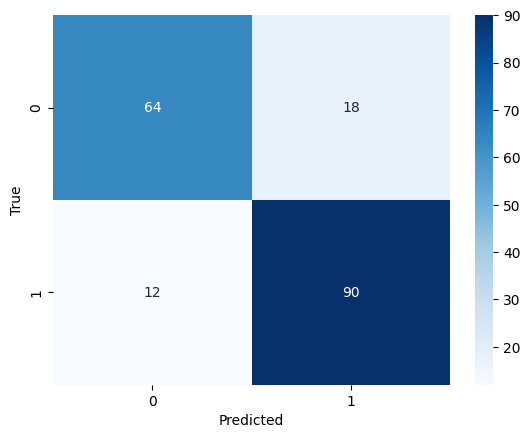

In [119]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

#### ANN

In [123]:
mlp_pipeline = make_pipeline(
    all_transformation,
    MLPClassifier(
        random_state=42,
        max_iter=30
    )
)

In [124]:
param_grid = {
    "mlpclassifier__hidden_layer_sizes": [(16,8,1), (32,8,1), (8,4,1)],
    "mlpclassifier__activation": ["relu", "tanh", "logistic"],
    "mlpclassifier__solver": ["adam", "sgd"],
    "mlpclassifier__alpha": [0.0001, 0.001, 0.01],  # L2 regularization
    "mlpclassifier__learning_rate": ["constant", "adaptive"]
}


In [125]:
mlp_model = GridSearchCV(mlp_pipeline, param_grid, cv=5, n_jobs=-1)


In [126]:
mlp_model.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('scaled',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'MaxHR',
                                                                          'FastingBS']),
                                                                        ('encoded',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['Sex',
                                                                          'ChestPainType',
                                                                          'RestingECG',
                                                                          'ExerciseAngina',
                                                                          'ST_Slope']),
                                                                        ('log',
                                                                         Pipeline(steps=[('log',
                                                                                          FunctionTransf...
                                                                         ['Cholesterol'])])),
                                       ('mlpclassifier',
                                        MLPClassifier(max_iter=30,
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid={'mlpclassifier__activation': ['relu', 'tanh',
                                                       'logistic'],
                         'mlpclassifier__alpha': [0.0001, 0.001, 0.01],
                         'mlpclassifier__hidden_layer_sizes': [(16, 8, 1),
                                                               (32, 8, 1),
                                                               (8, 4, 1)],
                         'mlpclassifier__learning_rate': ['constant',
                                                          'adaptive'],
                         'mlpclassifier__solver': ['adam', 'sgd']})

In [127]:
mlp_model.best_params_

{'mlpclassifier__activation': 'tanh',
 'mlpclassifier__alpha': 0.0001,
 'mlpclassifier__hidden_layer_sizes': (16, 8, 1),
 'mlpclassifier__learning_rate': 'constant',
 'mlpclassifier__solver': 'adam'}

In [ ]:
y_pred = mlp_model.predict(x_test)

In [ ]:
accuracy, f1, precision, recall, auc_score = evaluate_model(y_test, y_pred)

In [ ]:
eval_report.loc[len(eval_report)] = {
    'Model': 'MLP',
    'Accuracy': accuracy,
    'F1 Score': f1,
    'Precision': precision,
    'Recall': recall,
    'AUC Score': auc_score
}

In [ ]:
plot_confusion_matrix(y_test, y_pred)